# Comparing emulator-based MCMC results for ST data

In [1]:
from glob import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fatescal.tools import metrics
from fatescal.tools import unit_conversion as uc
from fatescal.config import VARIABLES_TO_ASSIMILATE, \
    PROJECT_ROOT_PATH, OBS_DATE_COLUMN_NAME, \
    AGGREGATION_FREQUENCY

In [2]:
# Tell pandas to display more float digits to explore small values
pd.options.display.float_format = '{:,.10f}'.format

In [3]:
# Define paths
result_dir_path = PROJECT_ROOT_PATH / 'data' / 'results'
aligned_dir_path = result_dir_path / 'aligned_obs_model'
plot_save_path = result_dir_path / 'plots' / 'publication_results'
color_json_path = result_dir_path.parent / 'dict'

result_paths: dict = {
    'single': {
        'ST_actual': aligned_dir_path / 
                    'HYY_synthetic_truth_1D_gpp_et' / 
                    'kalman_iter_0' / 
                    'M_1D_mean_HYY_synthetic_truth_1D_gpp_et.clm2.h1.2004-2013.csv',
        'ST_perturbed': PROJECT_ROOT_PATH / 'data' / 'sites' / 'hyy' /
                        'synthetic_truth' / 'HYY_synthetic_truth_gpp_et_1D_mean.csv',
    },
    'ensemble': {
        'UNI_ST': aligned_dir_path / 'HYY_ST_n256_uniform_1D_gpp_et' / 'mcmc',
        'LHC_ST': aligned_dir_path / 'HYY_ST_n256_lhc_1D_gpp_et' / 'mcmc',
        'LON_ST': aligned_dir_path / 'HYY_ST_n256_normlog_1D_gpp_et' / 'mcmc',
        'CES_ST': aligned_dir_path / 'HYY_ST_n128_K4_1D_gpp_et' / 'mcmc',
    },
}

In [4]:
with open(color_json_path / 'color_dict.json', 'r') as color_json:
    color_dict = json.load(color_json)

In [5]:
# Retrieve variable names
obs_var_names = [
    x['Observed']['csv_col_name']for x in VARIABLES_TO_ASSIMILATE
]
model_var_names = [
    x['CLM-FATES']['history_var_name'] for x in VARIABLES_TO_ASSIMILATE
]

In [6]:
# Read data
st_actual_df = pd.read_csv(
    result_paths['single']['ST_actual']
)
st_actual_df['time'] = pd.to_datetime(
    st_actual_df['time']
)
for var in model_var_names:
    st_actual_df[var] = uc.convert_unit(
        values=st_actual_df[var],
        unit_in='kg s-1',
        unit_out='g d-1'
    )
st_actual_df["QFLX_EVAP_TOT"] = \
    st_actual_df["QFLX_EVAP_TOT"] / 1000 # from g to kg

In [7]:
st_perturbed_df = pd.read_csv(
    result_paths['single']['ST_perturbed']
)
st_perturbed_df['samptime'] = pd.to_datetime(
    st_perturbed_df['samptime']
)

# Convert units
st_perturbed_df['GPP'] = uc.convert_unit(
    values=st_perturbed_df['GPP'].values,
    unit_in='µmol CO2 m-2 s-1',
    unit_out='kg C m-2 s-1',
)
st_perturbed_df["ET_gapf"] = uc.convert_unit(
    values=st_perturbed_df["ET_gapf"].values,
    unit_in='mmol H2O m-2 s-1',
    unit_out='kg H2O m-2 s-1',
)

for var in obs_var_names:
    st_perturbed_df[var] = uc.convert_unit(
        values=st_perturbed_df[var],
        unit_in='kg s-1',
        unit_out='g d-1'
    )
st_perturbed_df["ET_gapf"] = \
    st_perturbed_df["ET_gapf"] / 1000 # from g to kg

# Resample to one day
st_perturbed_1d_df = st_perturbed_df.set_index(
    OBS_DATE_COLUMN_NAME
).resample(AGGREGATION_FREQUENCY).mean()


---
# Load model outputs

In [8]:
mcmc_ensembles = []

for ensemble_path in result_paths['ensemble'].values():

    model_globs = sorted(glob(str(
        ensemble_path / 'M_*.csv'
    )))

    current_df_list = []

    for model_glob in model_globs:

        cur_df = pd.read_csv(model_glob)

        cur_df['time'] = pd.to_datetime(cur_df['time'])
        for var in model_var_names:
            cur_df[var] = uc.convert_unit(
                values=cur_df[var],
                unit_in='kg s-1',
                unit_out='g d-1'
            )
        cur_df["QFLX_EVAP_TOT"] = \
            cur_df["QFLX_EVAP_TOT"] / 1000 # from g to kg

        current_df_list.append(cur_df)
    
    mcmc_ensembles.append(current_df_list)

In [9]:
# Calculate stats
stats_df_list = []

for mcmc_ensemble in mcmc_ensembles:

    cur_df = pd.DataFrame()

    for var in model_var_names:
        mean, max, min = metrics.ensemble_mean_max_min(
            ensemble_df_list=mcmc_ensemble,
            column_name=var,
        )

        cur_df[var+"_mean"] = mean
        cur_df[var+"_max"] = max
        cur_df[var+"_min"] = min
    
    stats_df_list.append(cur_df)

In [10]:
len(mcmc_ensembles[0][0].head())

5

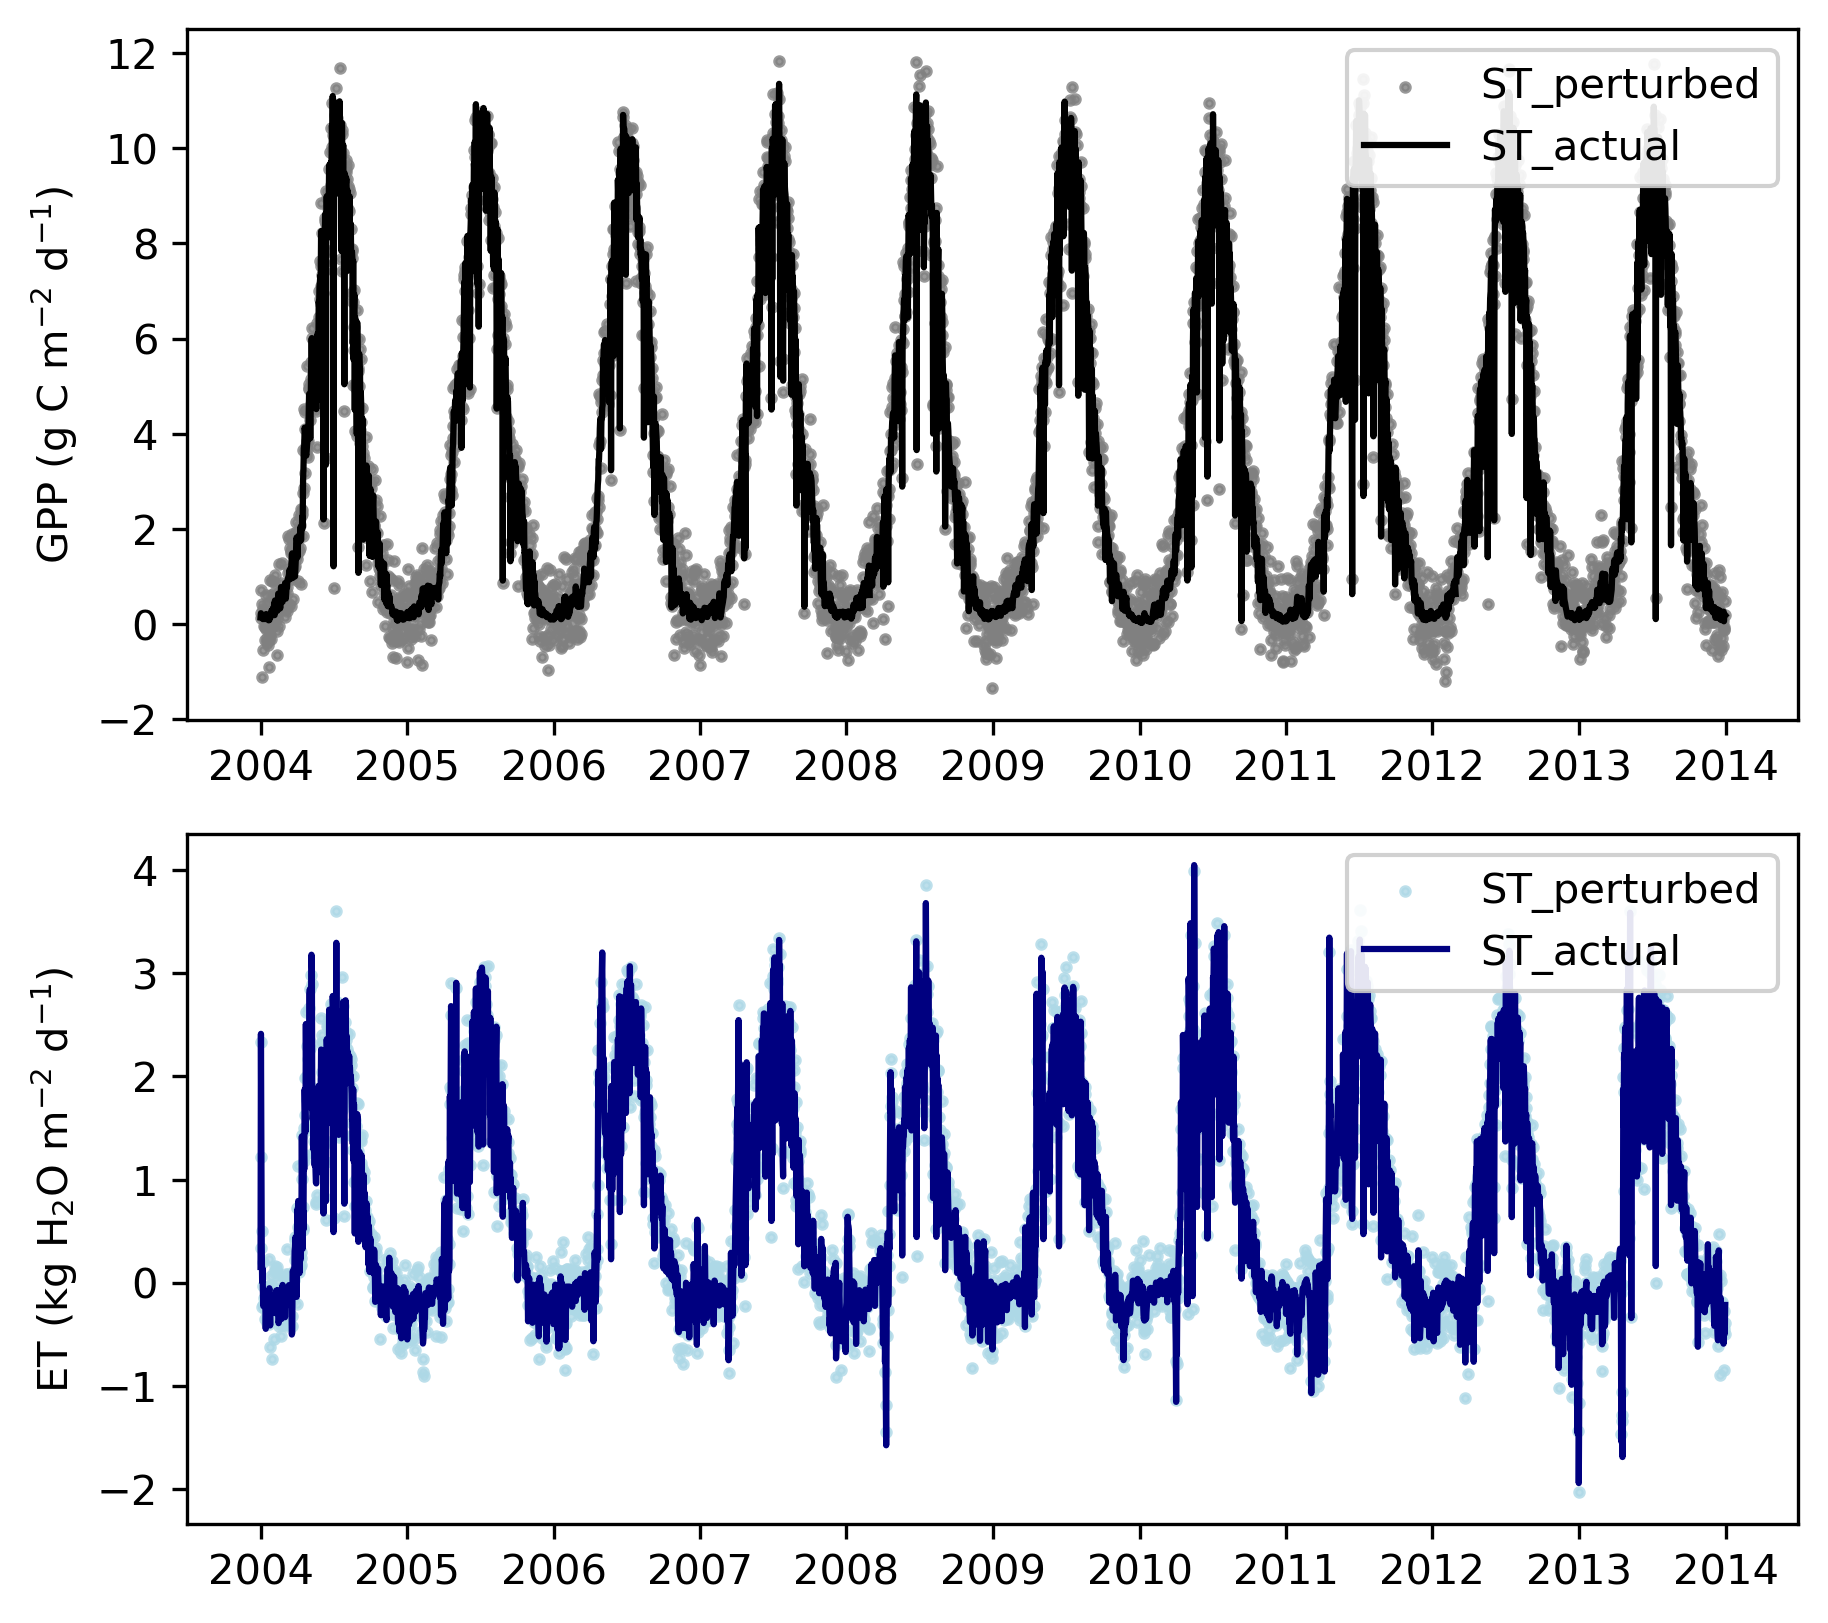

In [11]:
save_fig = False

fig, axes = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(16/2.54, 14/2.54),
    dpi=300
)

# PLOT GPP

axes[0].scatter(
    st_perturbed_1d_df.index,
    st_perturbed_1d_df['GPP'],
    s=4,
    alpha=0.8,
    color="grey",
    label="ST_perturbed"
)

axes[0].plot(
    st_actual_df['time'],
    st_actual_df['FATES_GPP'],#.rolling(window=14, min_periods=5).mean(),
    alpha=1,
    color="black",
    label="ST_actual",
    zorder=5
)

# PLOT ET
axes[1].scatter(
    st_perturbed_1d_df.index,
    st_perturbed_1d_df['ET_gapf'],
    s=4,
    alpha=0.8,
    color="lightblue",
    label="ST_perturbed"
)

axes[1].plot(
    st_actual_df['time'],
    st_actual_df['QFLX_EVAP_TOT'],#.rolling(window=14, min_periods=5).mean(),
    alpha=1,
    color="navy",
    label="ST_actual",
    zorder=5
)

axes[0].set_ylabel(
    "GPP (g C m$^{-2}$ d$^{-1}$)"
)
axes[1].set_ylabel(
    "ET (kg H$_2$O m$^{-2}$ d$^{-1}$)"
)

axes[0].legend(framealpha=0.9, loc="upper right")
axes[1].legend(framealpha=0.9, loc="upper right")

fig.tight_layout()

if save_fig:
    fig.savefig(
        plot_save_path / 'ST_actual_vs_ST_perturbed.png'
    )

In [12]:
st_actual_df

,time,FATES_GPP,QFLX_EVAP_TOT
0,2004-01-01,0.1365279840,0.1530517939
1,2004-01-02,0.2263691491,2.4123792384
2,2004-01-03,0.1887646205,1.2450716928
3,2004-01-04,0.1692178906,0.3442222915
4,2004-01-05,0.1826958845,0.0091341734
...,...,...,...
3648,2013-12-27,0.2592767232,-0.5903135712
3649,2013-12-28,0.0564719852,-0.4733707738
3650,2013-12-29,0.1852047763,-0.4474940688
3651,2013-12-30,0.1965207053,-0.4953369024


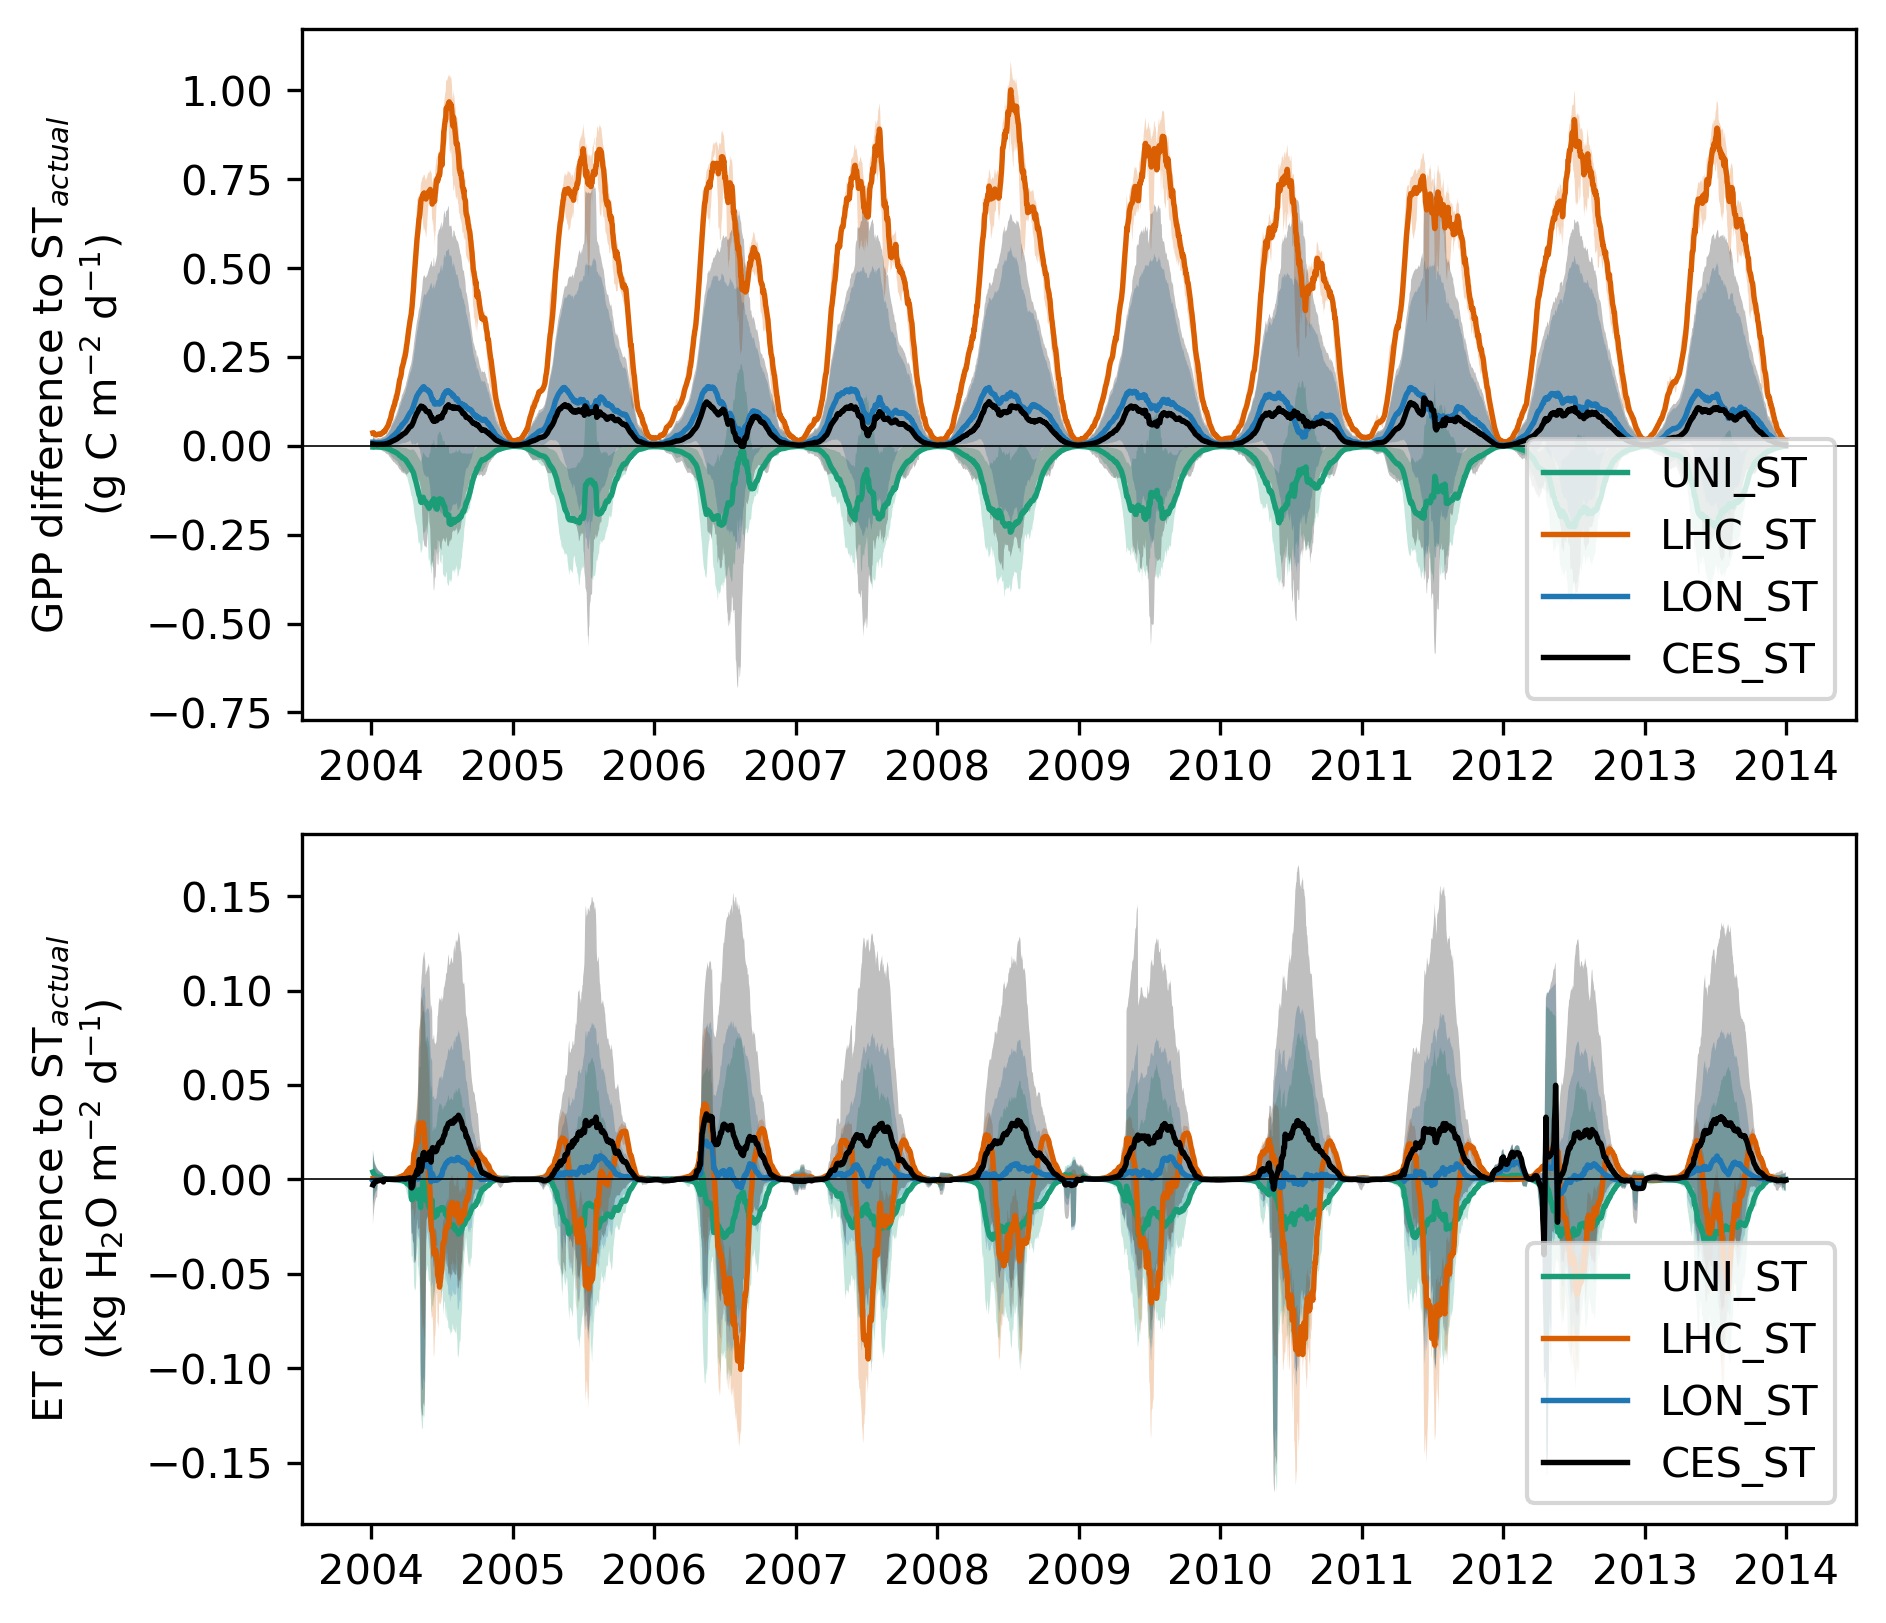

In [13]:
save_fig = False
window_size = 30

# DIFFERENCE PLOT
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(16/2.54, 14/2.54),
    dpi=300
)

for experiment_name, stats_df in zip(
    result_paths['ensemble'].keys(),
    stats_df_list
):
    # GPP
    axes[0].plot(
        st_perturbed_1d_df.index,
        (
            st_actual_df['FATES_GPP'].values - stats_df["FATES_GPP_mean"]
        ).rolling(window=window_size, min_periods=5).mean(),
        linewidth=1.3,
        alpha=1,
        color=color_dict[experiment_name],
        label=experiment_name
    )
    axes[0].fill_between(
        x=st_perturbed_1d_df.index,
        y1=(
            st_actual_df['FATES_GPP'].values - stats_df["FATES_GPP_min"]
        ).rolling(window=window_size, min_periods=5).mean(),
        y2=(
            st_actual_df['FATES_GPP'].values - stats_df["FATES_GPP_max"]
        ).rolling(window=14, min_periods=5).mean(),
        color=color_dict[experiment_name],
        alpha=0.25,
        edgecolor=None,
        #zorder=10,
        #label="MCMC ensemble range"
    )

    # ET
    axes[1].plot(
        st_perturbed_1d_df.index,
        (
            st_actual_df['QFLX_EVAP_TOT'].values - stats_df["QFLX_EVAP_TOT_mean"]
        ).rolling(window=window_size, min_periods=5).mean(),
        linewidth=1.3,
        alpha=1,
        color=color_dict[experiment_name],
        label=experiment_name
    )
    axes[1].fill_between(
        x=st_perturbed_1d_df.index,
        y1=(
            st_actual_df['QFLX_EVAP_TOT'].values - stats_df["QFLX_EVAP_TOT_min"]
        ).rolling(window=window_size, min_periods=5).mean(),
        y2=(
            st_actual_df['QFLX_EVAP_TOT'].values - stats_df["QFLX_EVAP_TOT_max"]
        ).rolling(window=14, min_periods=5).mean(),
        color=color_dict[experiment_name],
        alpha=0.25,
        edgecolor=None,
        #zorder=10,
        #label="MCMC ensemble range"
    )

axes[0].set_ylabel(
    "GPP difference to ST$_{actual}$\n(g C m$^{-2}$ d$^{-1}$)"
)
axes[1].set_ylabel(
    "ET difference to ST$_{actual}$\n(kg H$_2$O m$^{-2}$ d$^{-1}$)"
)

axes[0].axhline(0, linewidth=0.4, color="black")
axes[1].axhline(0, linewidth=0.4, color="black")
axes[0].legend(loc="lower right")
axes[1].legend(loc="lower right")

fig.tight_layout()
if save_fig:
    fig.savefig(
        plot_save_path / "st_ensemble_means_vs_st_actual.png",
        bbox_inches='tight'
    )

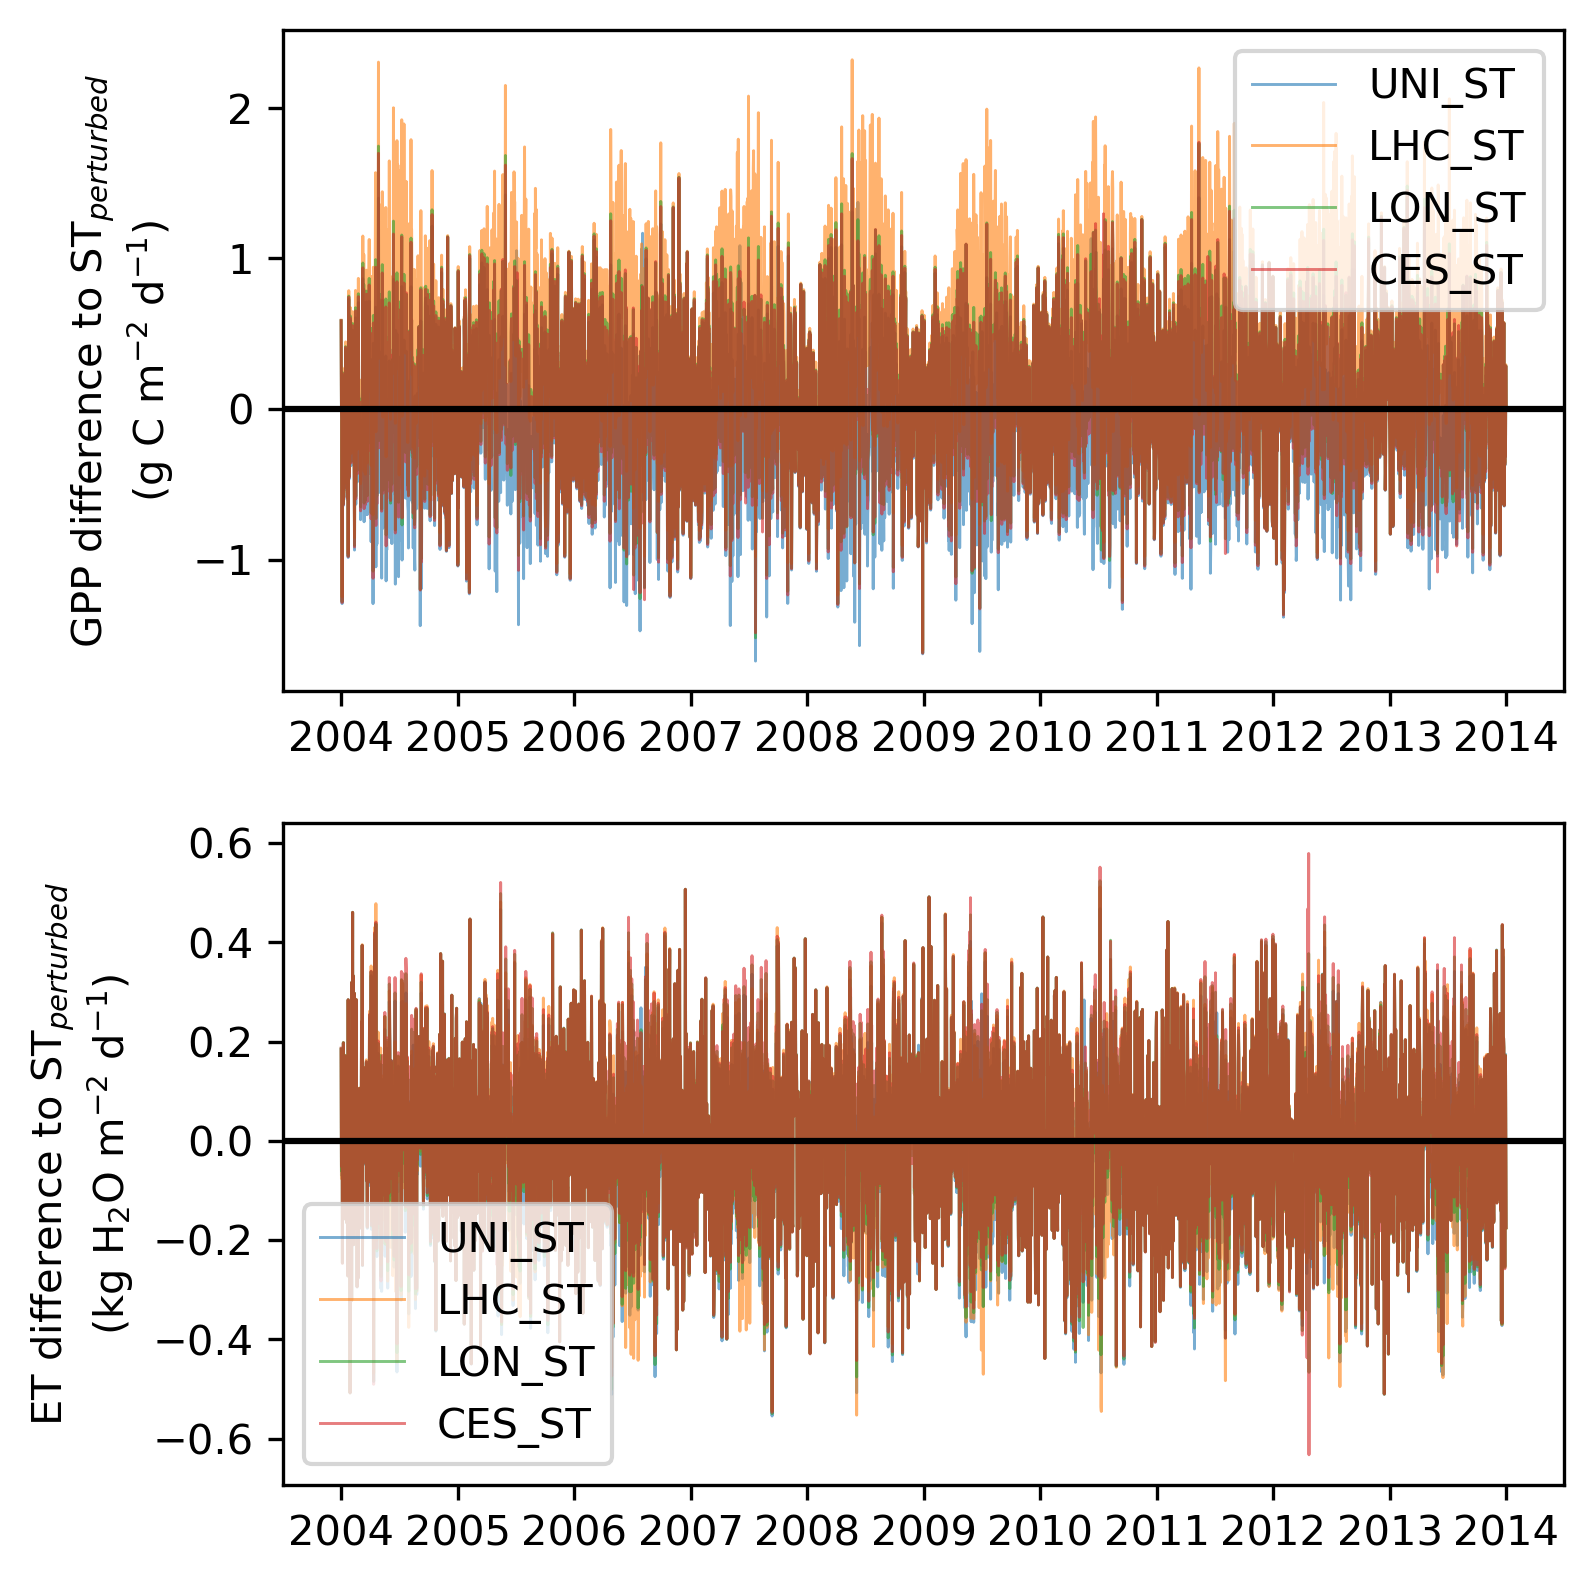

In [14]:
# DIFFERENCE PLOT ST_PERTURBED

fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(14/2.54, 16/2.54),
    dpi=300
)

for experiment_name, stats_df in zip(
    result_paths['ensemble'].keys(),
    stats_df_list
):
    axes[0].plot(
        st_perturbed_1d_df.index,
        st_perturbed_1d_df['GPP'].values - stats_df["FATES_GPP_mean"],
        linewidth=0.7,
        alpha=0.6,
        label=experiment_name
    )
    axes[1].plot(
        st_perturbed_1d_df.index,
        st_perturbed_1d_df['ET_gapf'].values - stats_df["QFLX_EVAP_TOT_mean"],
        linewidth=0.7,
        alpha=0.6,
        label=experiment_name
    )

axes[0].set_ylabel(
    "GPP difference to ST$_{perturbed}$\n(g C m$^{-2}$ d$^{-1}$)"
)
axes[1].set_ylabel(
    "ET difference to ST$_{perturbed}$\n(kg H$_2$O m$^{-2}$ d$^{-1}$)"
)

axes[0].axhline(0, color="black")
axes[1].axhline(0, color="black")
axes[0].legend()
axes[1].legend()

---
## Calculate statistics

In [15]:
from fatescal.tools import metrics

statistics_df = pd.DataFrame()

for experiment_name, stats_df in zip(
    result_paths['ensemble'].keys(),
    stats_df_list
):

    # GPP

    statistics_df.loc[experiment_name, "GPP_rmse"] = metrics.rmse(
        actual=st_perturbed_1d_df['GPP'].values,
        predicted=stats_df["FATES_GPP_mean"].values,
    )

    slope, intercept, r_value, p_value, std_err = \
        metrics.linear_regression(
            actual=st_perturbed_1d_df['GPP'].values,
            predicted=stats_df["FATES_GPP_mean"].values,
        )
    statistics_df.loc[experiment_name, "GPP_r2"] = r_value**2

    statistics_df.loc[experiment_name, "GPP_bias"] = metrics.bias(
        actual=st_perturbed_1d_df['GPP'].values,
        predicted=stats_df["FATES_GPP_mean"].values,
    )

    # ET

    statistics_df.loc[experiment_name, "ET_rmse"] = metrics.rmse(
        actual=st_perturbed_1d_df['ET_gapf'].values,
        predicted=stats_df["QFLX_EVAP_TOT_mean"].values,
    )

    slope, intercept, r_value, p_value, std_err = \
        metrics.linear_regression(
            actual=st_perturbed_1d_df['ET_gapf'].values,
            predicted=stats_df["QFLX_EVAP_TOT_mean"].values,
        )
    statistics_df.loc[experiment_name, "ET_r2"] = r_value**2

    statistics_df.loc[experiment_name, "ET_bias"] = metrics.bias(
        actual=st_perturbed_1d_df['ET_gapf'].values,
        predicted=stats_df["QFLX_EVAP_TOT_mean"].values,
    )

statistics_df.transpose()

,UNI_ST,LHC_ST,LON_ST,CES_ST
GPP_rmse,0.4863227091,0.6948660736,0.4795364141,0.4752502061
GPP_r2,0.9806426938,0.9779614881,0.9807135466,0.9807974759
GPP_bias,-0.0795105999,0.3968092137,0.0739539146,0.0509420753
ET_rmse,0.1655830267,0.1684293120,0.1653264304,0.1666942380
ET_r2,0.9757728292,0.9750976607,0.9756989036,0.9754680999
ET_bias,-0.0083311163,-0.0048141575,0.0034375281,0.0109352820


In [16]:
from importlib import reload
reload(metrics)

<module 'fatescal.tools.metrics' from '/cluster/work/users/lassetk/fates-parameter-calibration/fatescal/tools/metrics.py'>

In [17]:
from fatescal.tools import metrics

targets = ["GPP", "ET"]
metric_names = [
    "rmse_mean", "rmse_sd",
    "r2_mean", "r2_sd",
    "bias_mean", "bias_sd",
]
ensemble_stats_df = pd.DataFrame(
    columns=[x+"_"+y for x in targets for y in metric_names]
)

for experiment_name, mcmc_df_list in zip(
    result_paths['ensemble'].keys(),
    mcmc_ensembles
):

    # GPP
    ensemble_stats_df.loc[experiment_name, 0:len(metric_names)] = \
        metrics.get_ensemble_error_metrics(
            ensemble_df_list=mcmc_df_list,
            col_name="FATES_GPP",
            actual=st_perturbed_1d_df['GPP'].values,
        )

    # ET
    ensemble_stats_df.loc[experiment_name, len(metric_names):] = \
        metrics.get_ensemble_error_metrics(
            ensemble_df_list=mcmc_df_list,
            col_name="QFLX_EVAP_TOT",
            actual=st_perturbed_1d_df['ET_gapf'].values,
        )

ensemble_stats_df

/tmp/ipykernel_45791/184453969.py:19: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ensemble_stats_df.loc[experiment_name, 0:len(metric_names)] = \
/tmp/ipykernel_45791/184453969.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ensemble_stats_df.loc[experiment_name, len(metric_names):] = \
/tmp/ipykernel_45791/184453969.py:19: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ensemble_stats_df.loc[experiment_name, 0:len(metric_names)] = \
/tmp/ipykernel_45791/184453969.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels 

,GPP_rmse_mean,GPP_rmse_sd,GPP_r2_mean,GPP_r2_sd,GPP_bias_mean,GPP_bias_sd,ET_rmse_mean,ET_rmse_sd,ET_r2_mean,ET_r2_sd,ET_bias_mean,ET_bias_sd
UNI_ST,0.4883997271,0.0088068257,0.9805993875,0.0000962955,-0.0795105999,0.0275922987,0.1668030277,0.0015699241,0.9755651945,0.0002252158,-0.0083311163,0.0081498335
LHC_ST,0.6949809567,0.0111379092,0.9779571938,0.0000900891,0.3968092137,0.0115686094,0.1687061385,0.0005446973,0.9750295042,0.0000659019,-0.0048141575,0.0023651799
LON_ST,0.4847694440,0.0144143703,0.9806405420,0.0001668872,0.0739539146,0.0501212331,0.1667745082,0.0015330912,0.9754174707,0.0003329353,0.0034375281,0.0081167532
CES_ST,0.4872588595,0.0207019432,0.9805415206,0.0004621020,0.0509420753,0.0735645883,0.1686843005,0.0031937035,0.9751438454,0.0004255082,0.0109352820,0.0111572940


In [18]:
numeric_df = ensemble_stats_df.astype(float)

latex_str = numeric_df.to_latex(
    buf=None,
    float_format='{:.2}'.format,
    caption="Coming.",
)
print(latex_str)

\begin{table}
\centering
\caption{Coming.}
\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} &  GPP\_rmse\_mean &  GPP\_rmse\_sd &  GPP\_r2\_mean &  GPP\_r2\_sd &  GPP\_bias\_mean &  GPP\_bias\_sd &  ET\_rmse\_mean &  ET\_rmse\_sd &  ET\_r2\_mean &  ET\_r2\_sd &  ET\_bias\_mean &  ET\_bias\_sd \\
\midrule
UNI\_ST &           0.49 &       0.0088 &         0.98 &    9.6e-05 &          -0.08 &        0.028 &          0.17 &      0.0016 &        0.98 &   0.00023 &       -0.0083 &      0.0081 \\
LHC\_ST &           0.69 &        0.011 &         0.98 &      9e-05 &            0.4 &        0.012 &          0.17 &     0.00054 &        0.98 &   6.6e-05 &       -0.0048 &      0.0024 \\
LON\_ST &           0.48 &        0.014 &         0.98 &    0.00017 &          0.074 &         0.05 &          0.17 &      0.0015 &        0.98 &   0.00033 &        0.0034 &      0.0081 \\
CES\_ST &           0.49 &        0.021 &         0.98 &    0.00046 &          0.051 &        0.074 &          0.17 &      0.0032 &  

/tmp/ipykernel_45791/819669237.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_str = numeric_df.to_latex(


In [19]:
latex_str = statistics_df.transpose().to_latex(
    buf=None,
    float_format='{:.3}'.format,
    caption="Coming.",
)
print(latex_str)

\begin{table}
\centering
\caption{Coming.}
\begin{tabular}{lrrrr}
\toprule
{} &   UNI\_ST &   LHC\_ST &  LON\_ST &  CES\_ST \\
\midrule
GPP\_rmse &    0.486 &    0.695 &    0.48 &   0.475 \\
GPP\_r2   &    0.981 &    0.978 &   0.981 &   0.981 \\
GPP\_bias &  -0.0795 &    0.397 &   0.074 &  0.0509 \\
ET\_rmse  &    0.166 &    0.168 &   0.165 &   0.167 \\
ET\_r2    &    0.976 &    0.975 &   0.976 &   0.975 \\
ET\_bias  & -0.00833 & -0.00481 & 0.00344 &  0.0109 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_45791/1477546254.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_str = statistics_df.transpose().to_latex(


In [20]:
from fatescal.tools import metrics

for experiment_name, stats_df in zip(
    result_paths['ensemble'].keys(),
    stats_df_list
):
    rmse_gpp = metrics.rmse(
        actual=st_actual_df['FATES_GPP'].values,
        predicted=stats_df["FATES_GPP_mean"].values,
    )
    print(
        f"{experiment_name} RMSE GPP: {rmse_gpp}"
    )

    rmse_et = metrics.rmse(
        actual=st_actual_df['QFLX_EVAP_TOT'].values,
        predicted=stats_df["QFLX_EVAP_TOT_mean"].values,
    )
    print(
        f"{experiment_name} RMSE ET: {rmse_et}"
    )

UNI_ST RMSE GPP: 0.12752164994508733
UNI_ST RMSE ET: 0.020440162139799656
LHC_ST RMSE GPP: 0.5117322899962109
LHC_ST RMSE ET: 0.039480927653023065
LON_ST RMSE GPP: 0.09587241396530702
LON_ST RMSE ET: 0.016454360008669754
CES_ST RMSE GPP: 0.07446171705318458
CES_ST RMSE ET: 0.027507199506171257


In [55]:
import properscoring as ps

for mcmc_idx, mcmc_ensemble in zip(
    result_paths['ensemble'].keys(),
    mcmc_ensembles
):

    gpp_ens_mat = np.zeros(
        shape=(
            mcmc_ensemble[0].shape[0],
            len(mcmc_ensemble)
        )
    )

    et_ens_mat = np.zeros(
        shape=(
            mcmc_ensemble[0].shape[0],
            len(mcmc_ensemble)
        )
    )

    for idx, ens_df in enumerate(mcmc_ensemble):
        gpp_ens_mat[:, idx] = ens_df["FATES_GPP"].values
        et_ens_mat[:, idx] = ens_df["QFLX_EVAP_TOT"].values


    gpp_ens_crps = ps.crps_ensemble(
        observations=st_perturbed_1d_df['GPP'].values,
        forecasts=gpp_ens_mat,
        axis=1,
    )
    et_ens_crps = ps.crps_ensemble(
        observations=st_perturbed_1d_df['ET_gapf'].values,
        forecasts=et_ens_mat,
        axis=1,
    )

    print("MCMC", mcmc_idx ," GPP: ", round(np.nanmean(gpp_ens_crps), 3))
    print("MCMC", mcmc_idx ," ET: ", round(np.nanmean(et_ens_crps), 3))

MCMC UNI_ST  GPP:  0.374
MCMC UNI_ST  ET:  0.128
MCMC LHC_ST  GPP:  0.555
MCMC LHC_ST  ET:  0.133
MCMC LON_ST  GPP:  0.357
MCMC LON_ST  ET:  0.128
MCMC CES_ST  GPP:  0.344
MCMC CES_ST  ET:  0.127


---
# Add marginal dist plot

In [8]:
chain_dir_path = result_dir_path / 'mcmc_chains'

mcmc_chain_paths: dict = {
    'UNI_ST': chain_dir_path / 'HYY_ST_n256_uniform_1D_gpp_et' / \
        'mcmc_chain_pruned.csv',
    'LHC_ST': chain_dir_path / 'HYY_ST_n256_lhc_1D_gpp_et' / \
        'mcmc_chain_pruned.csv',
    'LON_ST': chain_dir_path / 'HYY_ST_n256_normlog_1D_gpp_et' / \
        'mcmc_chain_pruned.csv',
    'CES_ST': chain_dir_path / 'HYY_ST_n128_beta1_K4_1D_gpp_et' / \
        'mcmc_chain_pruned.csv',
}

chain_df_list = [
    pd.read_csv(x) for x in mcmc_chain_paths.values()
]

In [11]:
label_dict = {
    'CES_ST': 'CES$_{\mathrm{ST}}$',
    'UNI_ST': 'UNI$_{\mathrm{ST}}$',
    'LHC_ST': 'LHS$_{\mathrm{ST}}$',
    'LON_ST': 'LON$_{\mathrm{ST}}$',
}

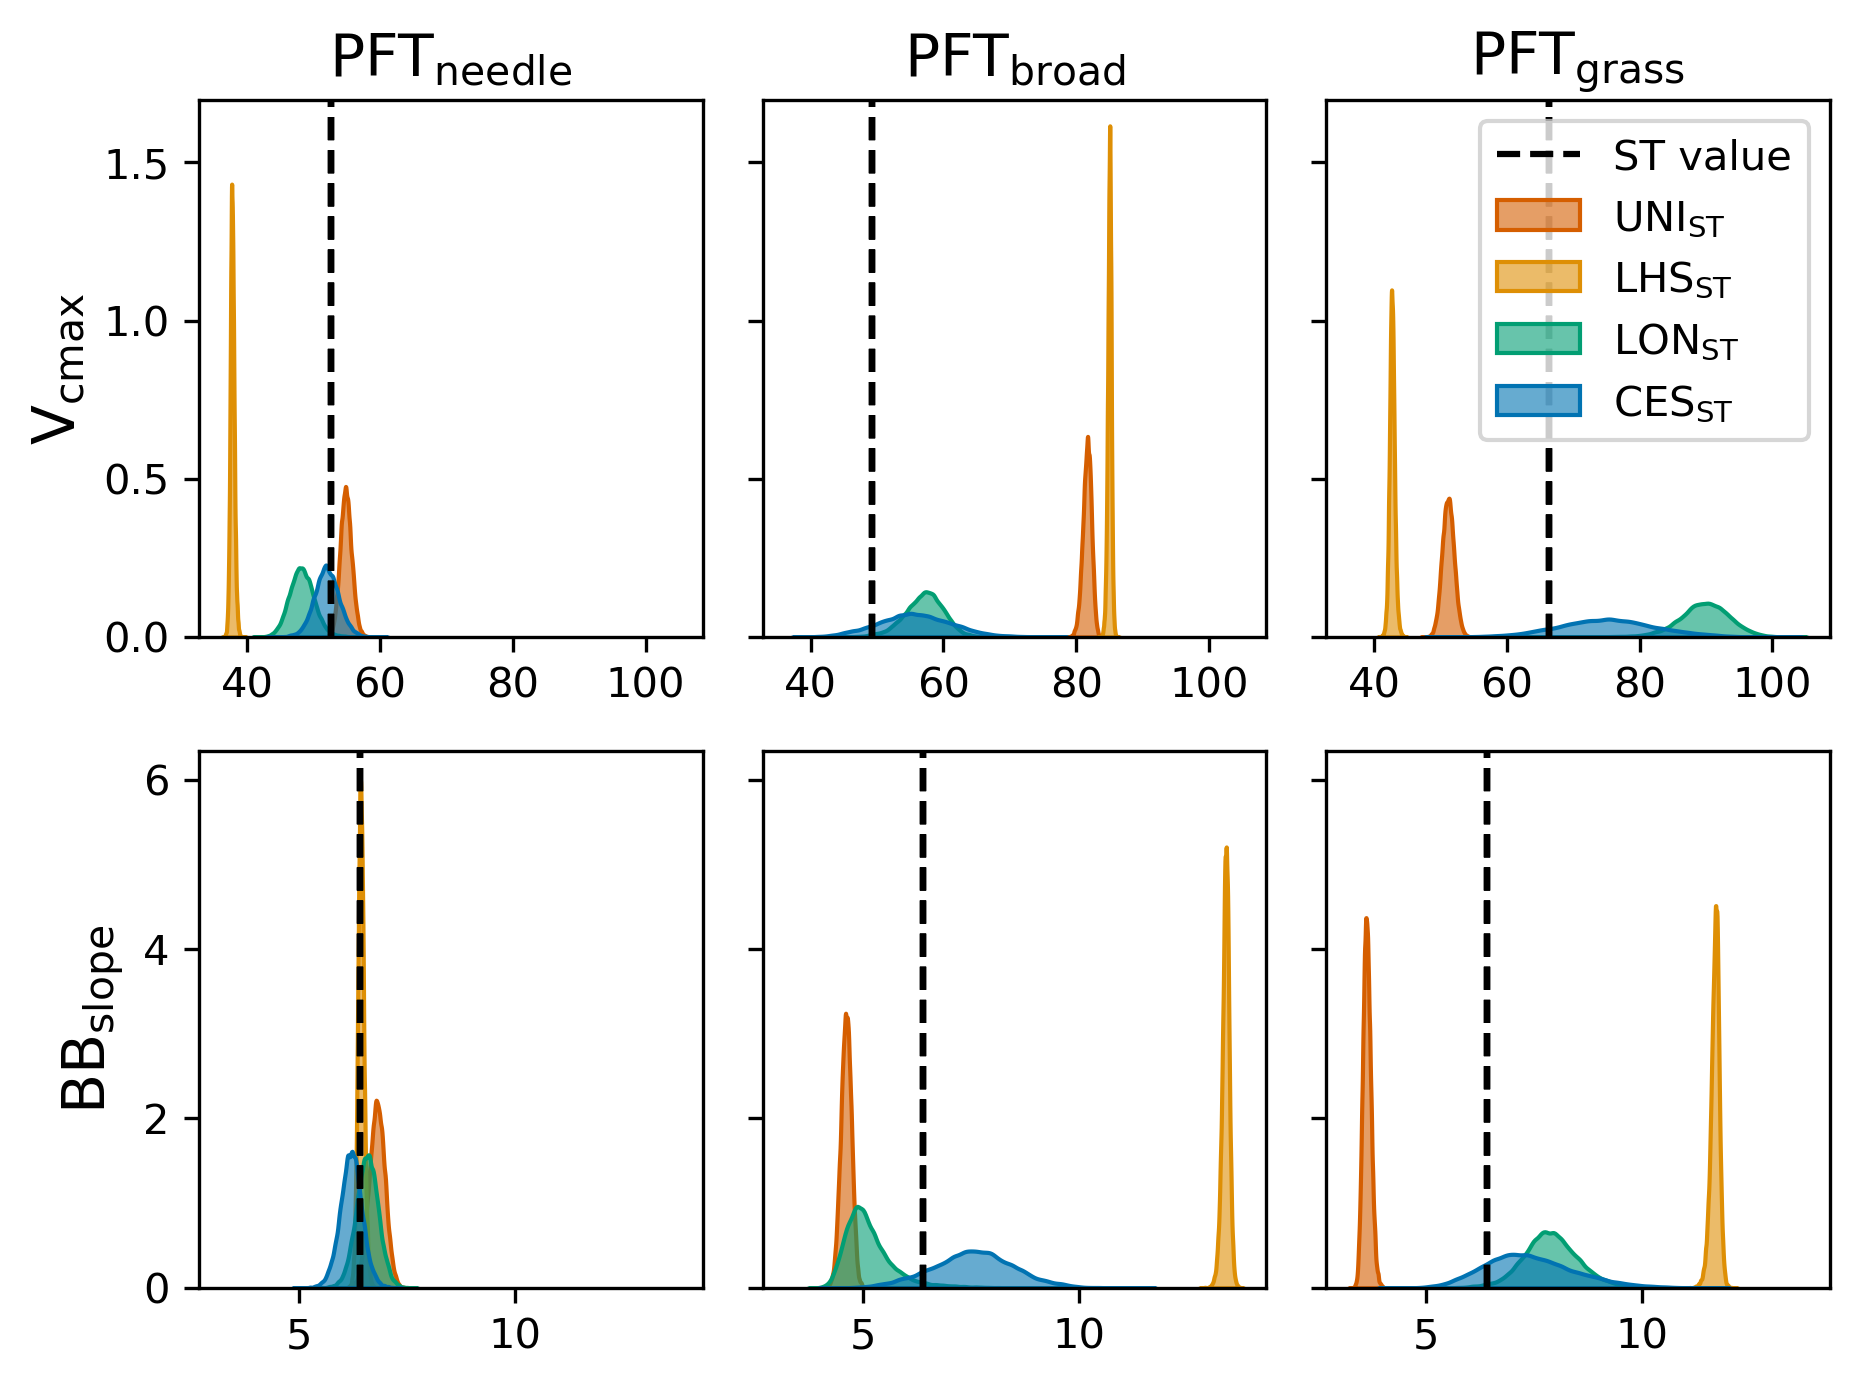

In [12]:
save_fig = True

import seaborn as sns

# Plot with synth_truth and enkf values
synth_truth_vcmax = [52.7, 49.3, 66.3]
synth_truth_bbslope = [6.4, 6.4, 6.4]
# enkf_vcmax_ens_means = [53.19, 55.54, 67.68]
# enkf_bbslope_ens_means = [6.2, 7.72, 6.43]

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    sharey='row',
    sharex='row',
    figsize=(16/2.54, 12/2.54),
    dpi=300,
)

count = 0
for df, exp_name in zip(chain_df_list, mcmc_chain_paths.keys()):

    # Density plot Vcmax
    for idx, pft_idx in enumerate(["2", "6", "11"]):
        # Vcmax
        axes[0, idx].axvline(
            synth_truth_vcmax[idx],
            color="black",
            linestyle="dashed",
            label="ST value" if (idx==2 and count==0) else None,
        )
        sns.kdeplot(
            data=df["fates_leaf_vcmax25top_PFT"+pft_idx],
            ax=axes[0, idx],
            fill=True,
            alpha=0.6,
            legend=False,
            label=label_dict[exp_name],
            color=color_dict[exp_name],
        )
        axes[0, idx].set_ylabel("")
        axes[0, idx].set_xlabel("")

        # BBslope
        axes[1, idx].axvline(
            synth_truth_bbslope[idx],
            color="black",
            linestyle="dashed"
        )
        sns.kdeplot(
            data=df["fates_leaf_stomatal_slope_ballberry_PFT"+pft_idx],
            ax=axes[1, idx],
            fill=True,
            alpha=0.6,
            legend=False,
            label=label_dict[exp_name],
            color=color_dict[exp_name],
        )
        axes[1, idx].set_ylabel("")
        axes[1, idx].set_xlabel("")
    
    count += 1

axes[0, 0].set_title("PFT$_{\mathrm{needle}}$", fontsize=14)
axes[0, 1].set_title("PFT$_{\mathrm{broad}}$", fontsize=14)
axes[0, 2].set_title("PFT$_{\mathrm{grass}}$", fontsize=14)

axes[0, 0].set_ylabel("V$_{\mathrm{cmax}}$", fontsize=14)
axes[1, 0].set_ylabel("BB$_{\mathrm{slope}}$", fontsize=14)

axes[0, 2].legend()

fig.tight_layout()
if save_fig:
    fig.savefig(
        plot_save_path / 'st_mcmc_strategy_kdeplots.png'
    )